In [57]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["cat"]))
BG_CLASSES  = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "automobile", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 2
INPUT_SIZE = 224
BATCH_SIZE = 128
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'cifar10_2class.h5'

TRAIN = False

In [237]:
from matplotlib import cm

def load_colors(cmap_name, num_colors=None):
    return cm.get_cmap(cmap_name, num_colors).colors

In [224]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

Transform the training data as follows:
    - Remove all images with labels OOD_CLASSES
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        
Transform the test data as follows:
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        - 2: image is one of OOD_CLASSES (i.e. it's a horse, ship, or truck)

In [225]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'], 
                        target_transform=label_transform)
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'],
                               target_transform=label_transform)
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'], 
                       target_transform=label_transform)
cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                                         sampler=ImbalancedDatasetSampler(cifar10_train),
                                         num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [226]:
model = create_model("vgg16")
model = model.to(device)
load_model(model, path='vgg16_fine_3.pt')

In [251]:
def load_ood_data(dataset):
    data = {}    
    with h5py.File(RESULTS_FILE, 'r') as f:
        data['labels_val'] = f['val/labels'][()]
        data['labels_ood'] = f[f'{dataset}/labels'][()]
        data['labels'] = np.concatenate([data['labels_val'], data['labels_ood']], axis=0)

        data['mahalanobis_dist_val'] = f['val/mahalanobis_dists'][()]
        data['mahalanobis_dist_ood'] = f[f'{dataset}/mahalanobis_dists'][()]
        data['mahalanobis_dist'] = np.concatenate([data['mahalanobis_dist_val'], data['mahalanobis_dist_ood']], axis=0)

        data['mahalanobis_features_train'] = f['train_no_aug/mahalanobis_features'][()]
        data['mahalanobis_features_val'] = f['val/mahalanobis_features'][()]
        data['mahalanobis_features_ood'] = f[f'{dataset}/mahalanobis_features'][()]
        data['mahalanobis_features'] = np.concatenate([data['mahalanobis_features_val'], data['mahalanobis_features_ood']], axis=0)

        data['softmax_outputs_val'] = f['val/softmax_outputs'][()]
        data['softmax_outputs_ood'] = f[f'{dataset}/softmax_outputs'][()]
        data['softmax_outputs'] = np.concatenate([data['softmax_outputs_val'], data['softmax_outputs_ood']], axis=0)

        data['mc_softmax_outputs_val'] = f['val/mc_outputs'][()]
        data['mc_softmax_outputs_ood'] = f[f'{dataset}/mc_outputs'][()]
        data['mc_softmax_outputs'] = np.concatenate([data['mc_softmax_outputs_val'], data['mc_softmax_outputs_ood']], axis=1)

        data['svm_scores_val'] = f['val/svm_scores'][()]
        data['svm_scores_ood'] = f[f'{dataset}/svm_scores'][()]
        data['svm_scores'] = np.concatenate([data['svm_scores_val'], data['svm_scores_ood']], axis=0)
        
        data['svm_feats_val'] = f['val/svm/layer_16'][()]
        data['svm_feats_ood'] = f[f'{dataset}/svm/layer_16'][()]    
        data['svm_features'] = np.concatenate([data['svm_feats_val'], data['svm_feats_ood']], axis=0)
    
    return data

# Visualizations

### Logit value distributions

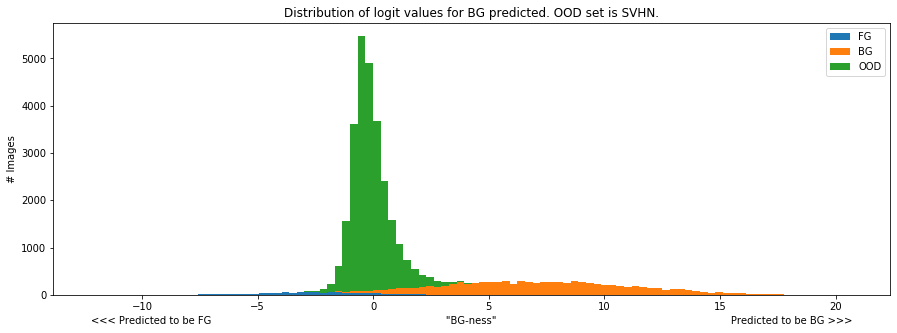

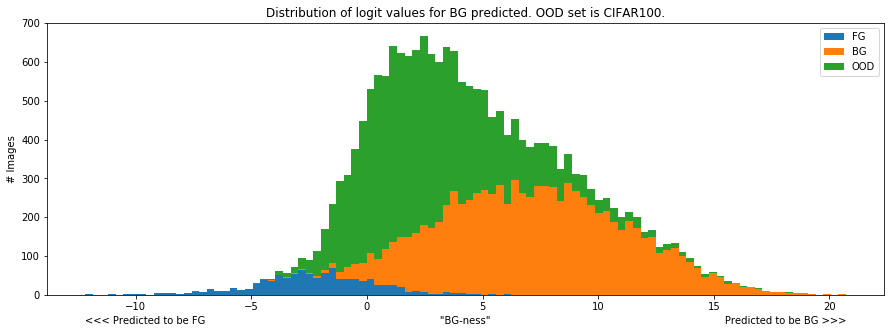

In [228]:
for dataset, title in [('svhn', 'SVHN'), ('ood', 'CIFAR100')]:
    data = load_ood_data(dataset)
    
    plt.figure(figsize=(15, 5))

    fg_points = data['softmax_outputs'][data['labels'] == 0][:,1]
    bg_points = data['softmax_outputs'][data['labels'] == 1][:,1]
    ood_points = data['softmax_outputs'][data['labels'] >= 2][:,1]

    plt.hist((fg_points, bg_points, ood_points), bins=100, stacked=True, log=False, label=["FG", "BG", "OOD"])
    plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
    plt.ylabel('# Images')
    plt.title(f"Distribution of logit values for BG predicted. OOD set is {title}.")
    plt.legend()
    plt.show()

## UMAP Embedding

### Penultimate feature space

In [ ]:
text_labels = ['FG', 'BG', 'OOD']
colors = load_colors("tab10")

for dataset, title in [('svhn', 'SVHN'), ('ood', 'CIFAR100')]:
    data = load_ood_data(dataset)
    data['labels'][data['labels'] > NUM_CLASSES] = NUM_CLASSES    

    embedding = umap.UMAP().fit_transform(data['mahalanobis_features'])

    fig, ax = plt.subplots(figsize=(15, 10))

    for label in range(len(text_labels)):
        x = embedding[:,0][data['labels'] == label]
        y = embedding[:,1][data['labels'] == label]
        ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    ax.legend()
    plt.show()

### Early layer feature space

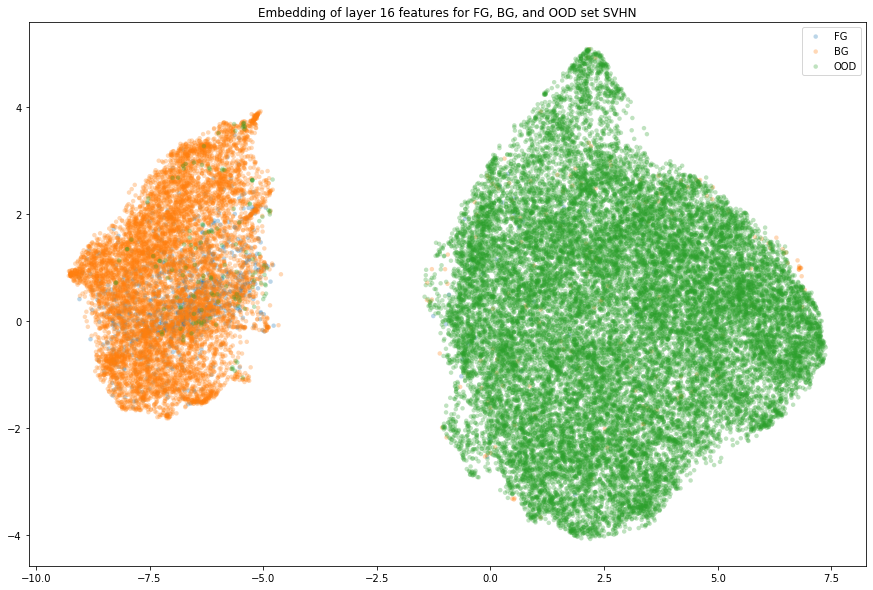

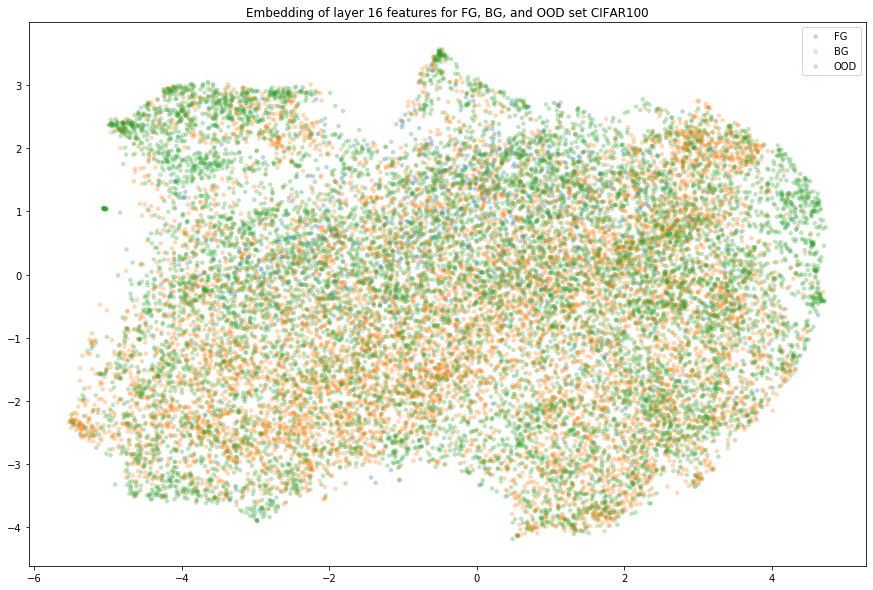

In [266]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
text_labels = ['FG', 'BG', 'OOD']
    
for dataset, title in [('svhn', 'SVHN'), ('ood', 'CIFAR100')]:
    data = load_ood_data(dataset)
    data['labels'][data['labels'] > NUM_CLASSES] = NUM_CLASSES    

    embedding = umap.UMAP().fit_transform(data['svm_features'])

    fig, ax = plt.subplots(figsize=(15, 10))

    for label in range(len(text_labels)):
        x = embedding[:,0][data['labels'] == label]
        y = embedding[:,1][data['labels'] == label]
        ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of layer 16 features for FG, BG, and OOD set {title}")

    ax.legend()
    plt.show()

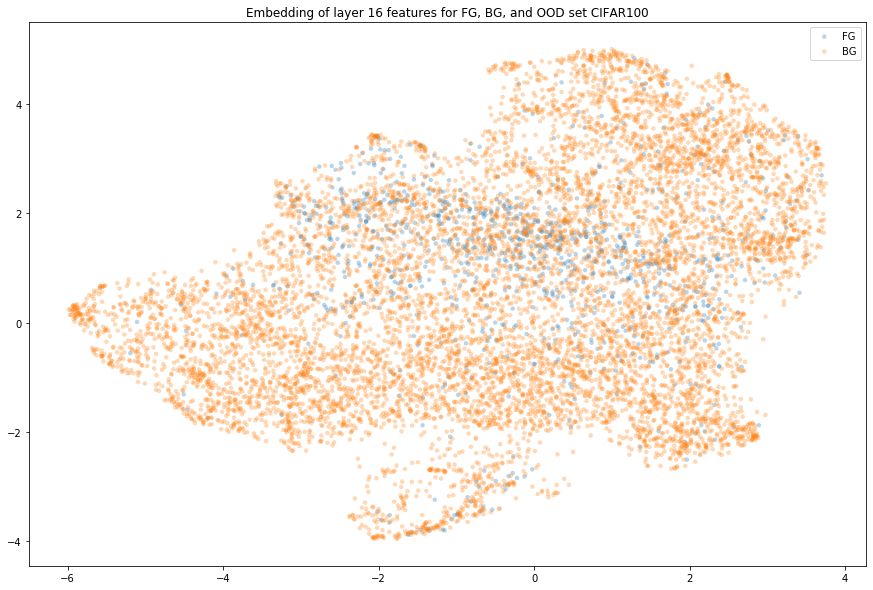

In [268]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
text_labels = ['FG', 'BG']
    
for dataset, title in [('ood', 'CIFAR100')]:
    data = load_ood_data(dataset)
    mask = data['labels'] < NUM_CLASSES
    labels = data['labels'][mask]    
    features = data['svm_features'][mask]
        
    embedding = umap.UMAP().fit_transform(features)

    fig, ax = plt.subplots(figsize=(15, 10))

    for label in range(len(text_labels)):
        x = embedding[:,0][labels == label]
        y = embedding[:,1][labels == label]
        ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of layer 16 features for FG, BG, and OOD set {title}")

    ax.legend()
    plt.show()

## Distinguishing Top 20 Most different CIFAR100 OOD from FG BG

OOD Class 0
	Detection Err: 0.48015
	AUROC: 0.735598
	FPR@95%TPR: 0.9203


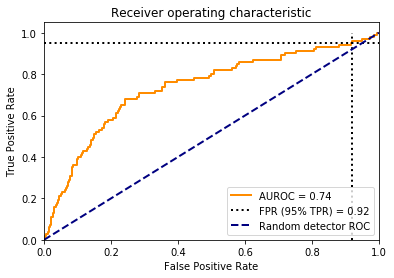

OOD Class 1
	Detection Err: 0.4827
	AUROC: 0.532327
	FPR@95%TPR: 0.9254


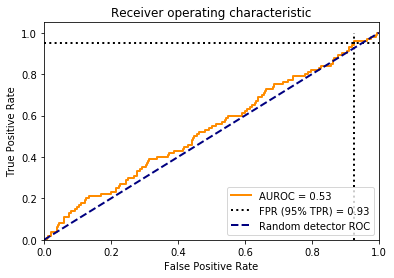

OOD Class 2
	Detection Err: 0.49955
	AUROC: 0.506666
	FPR@95%TPR: 0.9928


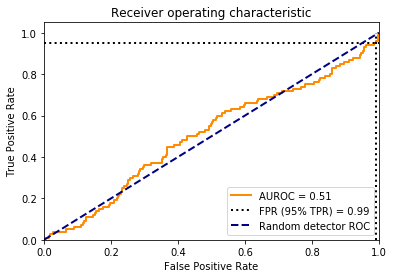

OOD Class 3
	Detection Err: 0.49165
	AUROC: 0.39044100000000004
	FPR@95%TPR: 0.9746


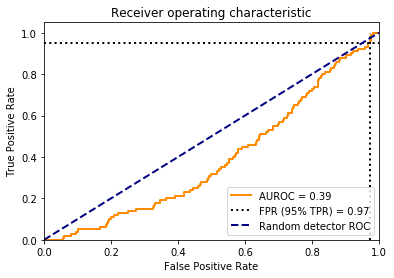

OOD Class 4
	Detection Err: 0.4722
	AUROC: 0.50483
	FPR@95%TPR: 0.9044


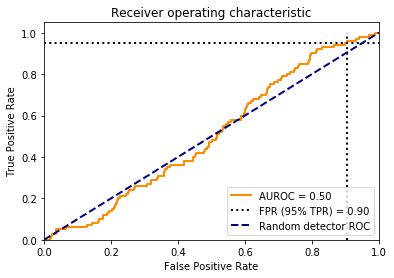

OOD Class 5
	Detection Err: 0.4631
	AUROC: 0.632653
	FPR@95%TPR: 0.89


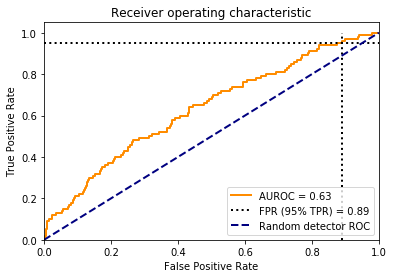

OOD Class 6
	Detection Err: 0.458
	AUROC: 0.6284829999999999
	FPR@95%TPR: 0.8903


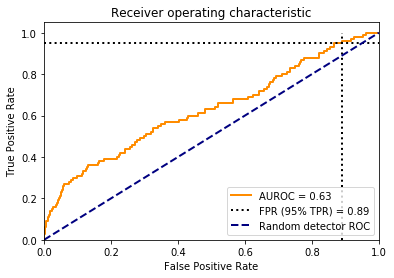

OOD Class 7
	Detection Err: 0.4113
	AUROC: 0.692334
	FPR@95%TPR: 0.8059


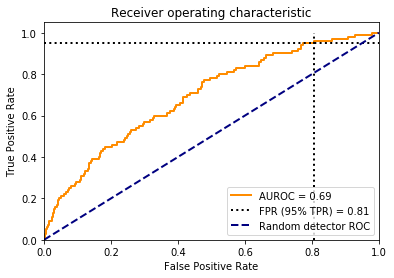

OOD Class 8
	Detection Err: 0.4998
	AUROC: 0.404366
	FPR@95%TPR: 0.9865


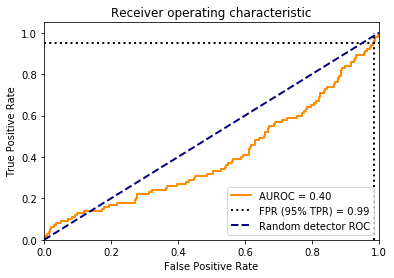

OOD Class 9
	Detection Err: 0.4284
	AUROC: 0.7523770000000001
	FPR@95%TPR: 0.819


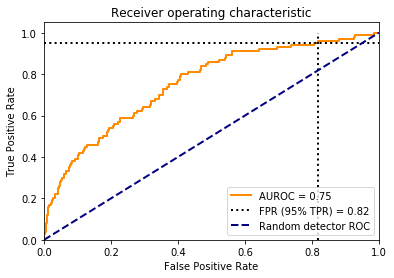

OOD Class 10
	Detection Err: 0.4788
	AUROC: 0.6451979999999999
	FPR@95%TPR: 0.9177


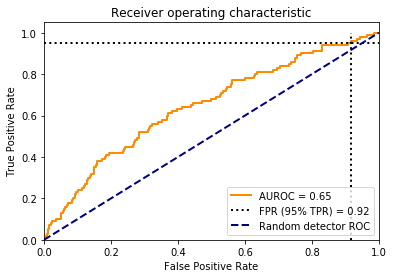

OOD Class 11
	Detection Err: 0.49975
	AUROC: 0.446222
	FPR@95%TPR: 0.9869


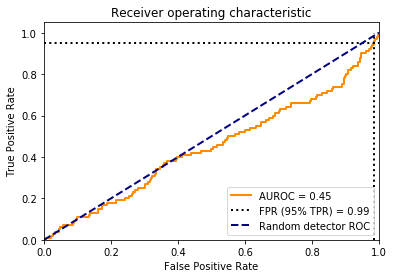

OOD Class 12
	Detection Err: 0.46005
	AUROC: 0.557087
	FPR@95%TPR: 0.9093


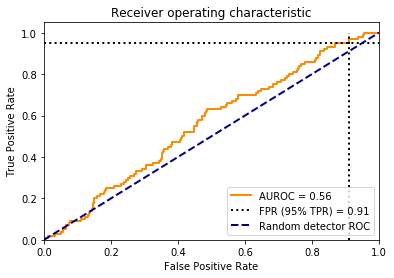

OOD Class 13
	Detection Err: 0.49775
	AUROC: 0.4205395
	FPR@95%TPR: 0.9789


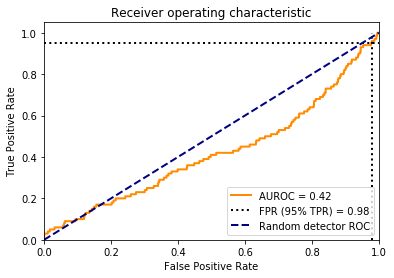

OOD Class 14
	Detection Err: 0.4897
	AUROC: 0.530036
	FPR@95%TPR: 0.9524


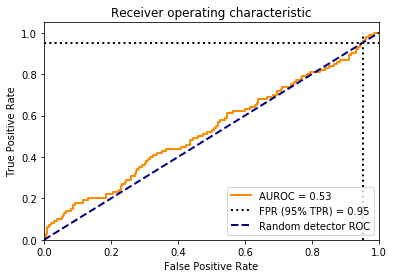

OOD Class 15
	Detection Err: 0.49355
	AUROC: 0.442364
	FPR@95%TPR: 0.9554


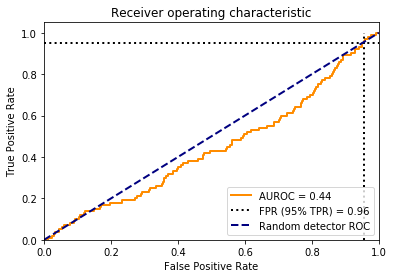

OOD Class 16
	Detection Err: 0.4641
	AUROC: 0.708442
	FPR@95%TPR: 0.9225


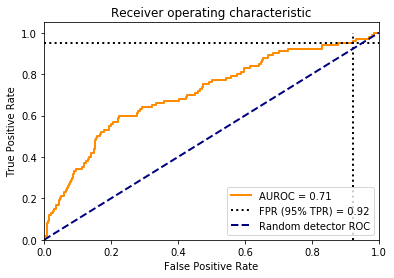

OOD Class 17
	Detection Err: 0.47125
	AUROC: 0.511808
	FPR@95%TPR: 0.907


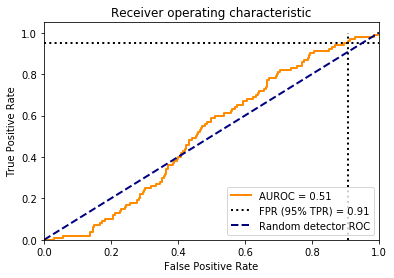

OOD Class 18
	Detection Err: 0.40325
	AUROC: 0.7473779999999999
	FPR@95%TPR: 0.8212


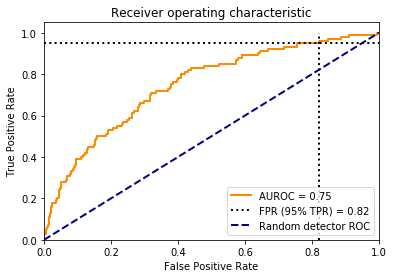

OOD Class 19
	Detection Err: 0.49575
	AUROC: 0.419821
	FPR@95%TPR: 0.9701


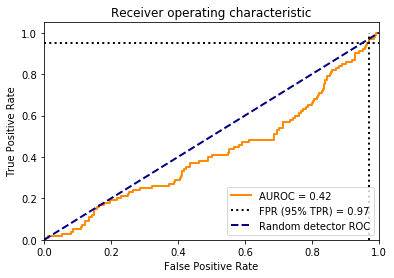

OOD Class 20
	Detection Err: 0.3632
	AUROC: 0.825311
	FPR@95%TPR: 0.7198


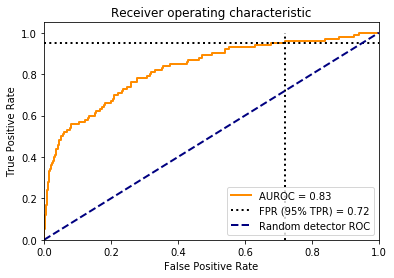

OOD Class 21
	Detection Err: 0.483
	AUROC: 0.408794
	FPR@95%TPR: 0.9515


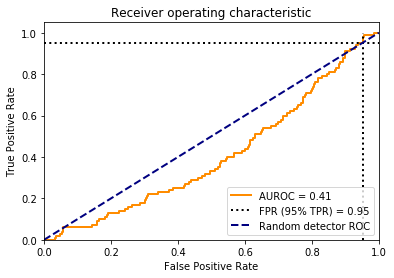

OOD Class 22
	Detection Err: 0.4622
	AUROC: 0.7182270000000001
	FPR@95%TPR: 0.8919


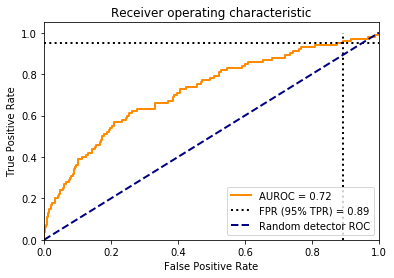

OOD Class 23
	Detection Err: 0.2363
	AUROC: 0.8823789999999999
	FPR@95%TPR: 0.4326


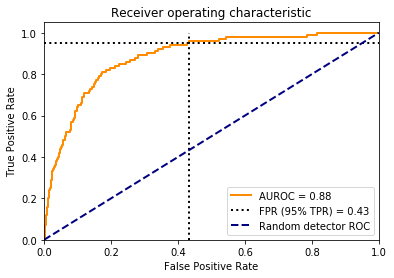

OOD Class 24
	Detection Err: 0.43475
	AUROC: 0.738552
	FPR@95%TPR: 0.8323


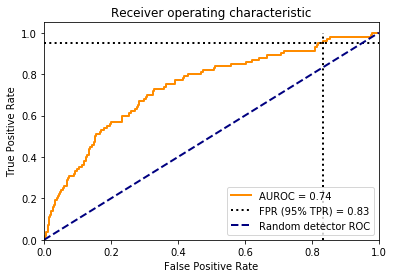

OOD Class 25
	Detection Err: 0.46915
	AUROC: 0.64783
	FPR@95%TPR: 0.8983


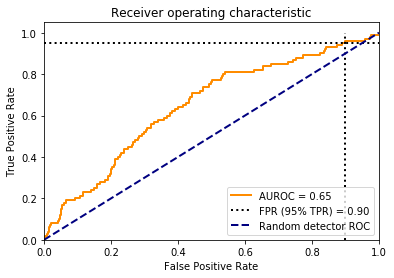

OOD Class 26
	Detection Err: 0.46865
	AUROC: 0.6594280000000001
	FPR@95%TPR: 0.924


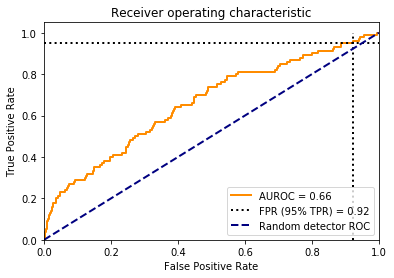

OOD Class 27
	Detection Err: 0.43895
	AUROC: 0.6046699999999999
	FPR@95%TPR: 0.8438


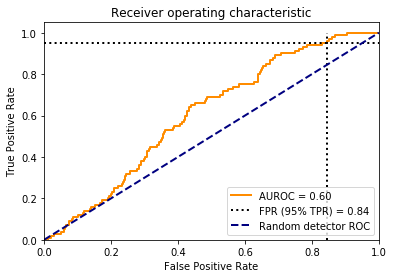

OOD Class 28
	Detection Err: 0.38915
	AUROC: 0.713933
	FPR@95%TPR: 0.7383


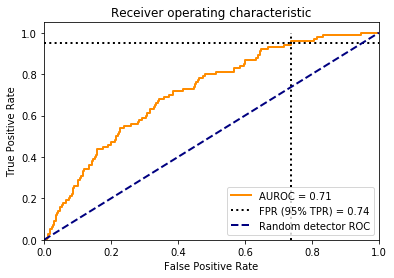

OOD Class 29
	Detection Err: 0.49570000000000003
	AUROC: 0.54097
	FPR@95%TPR: 0.9679


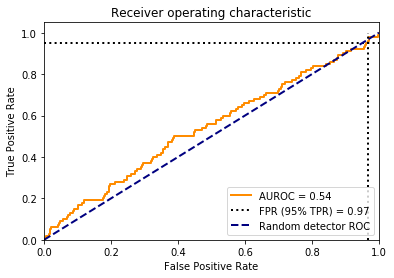

OOD Class 30
	Detection Err: 0.274
	AUROC: 0.802434
	FPR@95%TPR: 0.5319


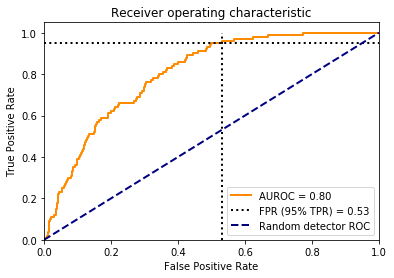

OOD Class 31
	Detection Err: 0.49610000000000004
	AUROC: 0.427448
	FPR@95%TPR: 0.9522


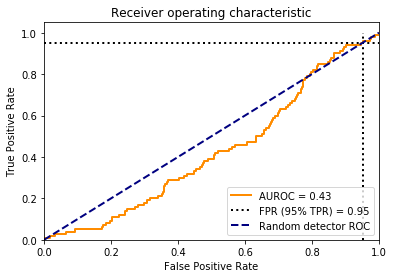

OOD Class 32
	Detection Err: 0.49885
	AUROC: 0.4411550000000001
	FPR@95%TPR: 0.9796


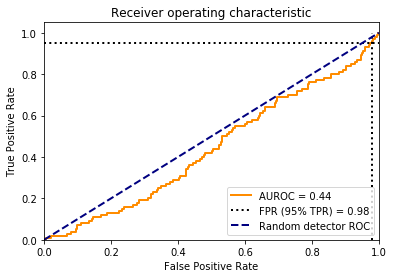

OOD Class 33
	Detection Err: 0.39335000000000003
	AUROC: 0.7598349999999999
	FPR@95%TPR: 0.7467


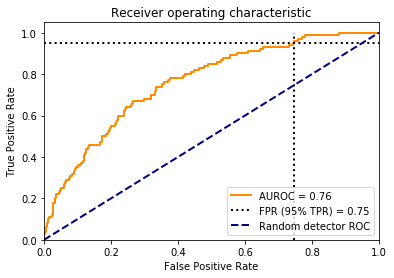

OOD Class 34
	Detection Err: 0.4565
	AUROC: 0.485213
	FPR@95%TPR: 0.8844


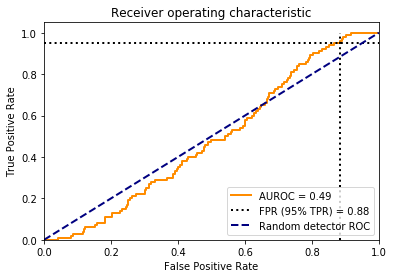

OOD Class 35
	Detection Err: 0.49885
	AUROC: 0.450847
	FPR@95%TPR: 0.9876


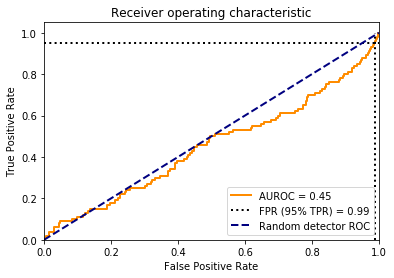

OOD Class 36
	Detection Err: 0.48095
	AUROC: 0.505073
	FPR@95%TPR: 0.9399


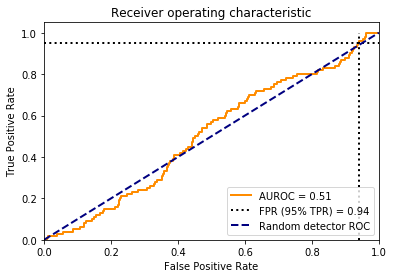

OOD Class 37
	Detection Err: 0.4986
	AUROC: 0.39145300000000005
	FPR@95%TPR: 0.9873


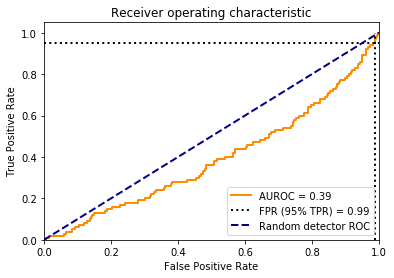

OOD Class 38
	Detection Err: 0.48335
	AUROC: 0.530782
	FPR@95%TPR: 0.9296


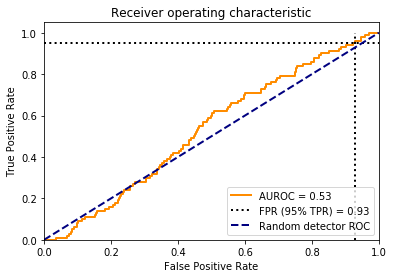

OOD Class 39
	Detection Err: 0.09930000000000003
	AUROC: 0.9618180000000001
	FPR@95%TPR: 0.1677


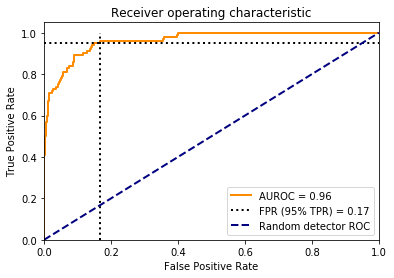

OOD Class 40
	Detection Err: 0.45665
	AUROC: 0.6930409999999998
	FPR@95%TPR: 0.874


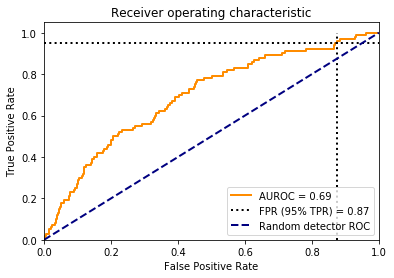

OOD Class 41
	Detection Err: 0.4925
	AUROC: 0.592984
	FPR@95%TPR: 0.9551


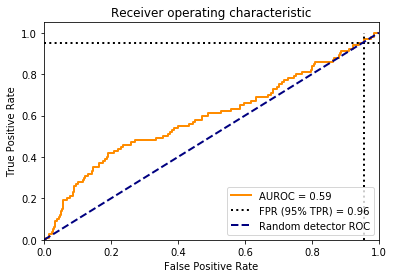

OOD Class 42
	Detection Err: 0.4898
	AUROC: 0.5808270000000001
	FPR@95%TPR: 0.9528


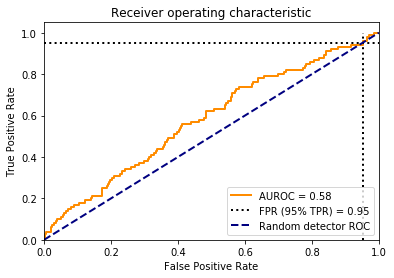

OOD Class 43
	Detection Err: 0.46240000000000003
	AUROC: 0.549863
	FPR@95%TPR: 0.8848


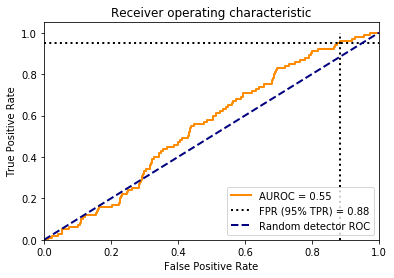

OOD Class 44
	Detection Err: 0.4885
	AUROC: 0.657762
	FPR@95%TPR: 0.9501


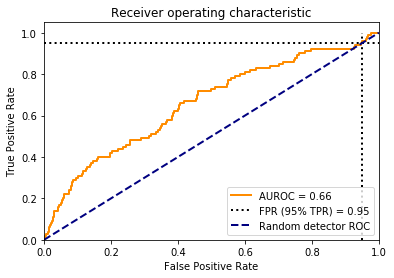

OOD Class 45
	Detection Err: 0.46995000000000003
	AUROC: 0.611702
	FPR@95%TPR: 0.903


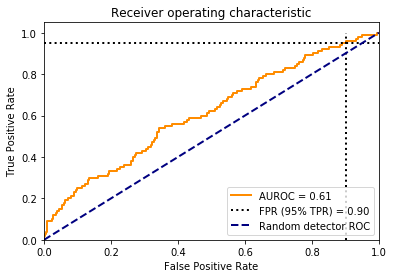

OOD Class 46
	Detection Err: 0.49295
	AUROC: 0.44451999999999997
	FPR@95%TPR: 0.9532


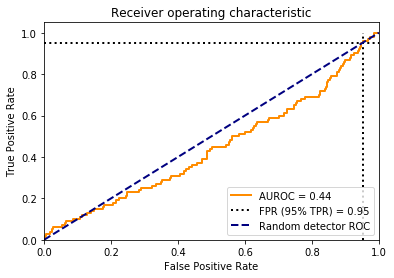

OOD Class 47
	Detection Err: 0.42310000000000003
	AUROC: 0.6366189999999999
	FPR@95%TPR: 0.8132


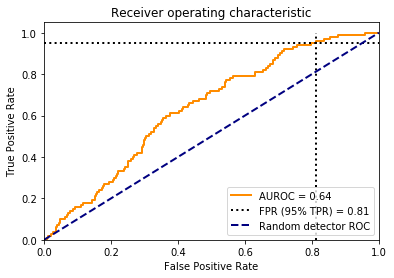

OOD Class 48
	Detection Err: 0.49725
	AUROC: 0.46862400000000004
	FPR@95%TPR: 0.9744


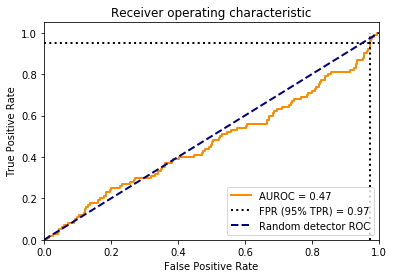

OOD Class 49
	Detection Err: 0.4329
	AUROC: 0.630602
	FPR@95%TPR: 0.8258


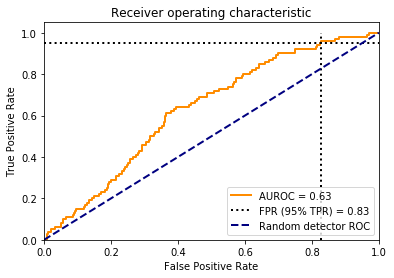

OOD Class 50
	Detection Err: 0.46505
	AUROC: 0.559931
	FPR@95%TPR: 0.8978


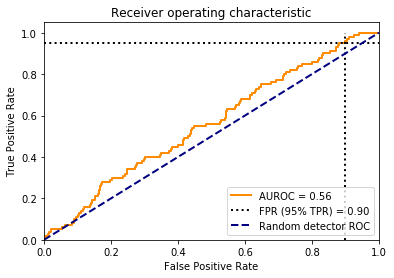

OOD Class 51
	Detection Err: 0.49315
	AUROC: 0.538649
	FPR@95%TPR: 0.9658


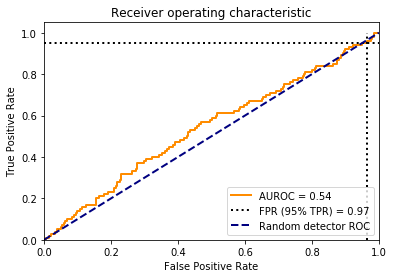

OOD Class 52
	Detection Err: 0.4824
	AUROC: 0.49128499999999997
	FPR@95%TPR: 0.9248


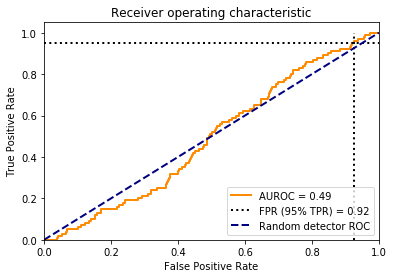

OOD Class 53
	Detection Err: 0.35960000000000003
	AUROC: 0.8456950000000001
	FPR@95%TPR: 0.717


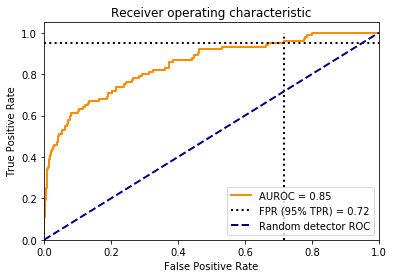

OOD Class 54
	Detection Err: 0.47135000000000005
	AUROC: 0.647511
	FPR@95%TPR: 0.9276


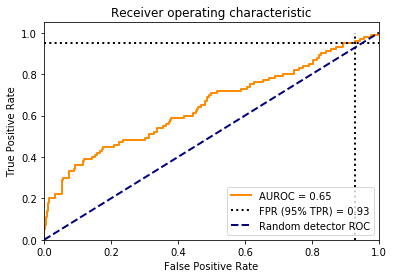

OOD Class 55
	Detection Err: 0.48295000000000005
	AUROC: 0.579899
	FPR@95%TPR: 0.9425


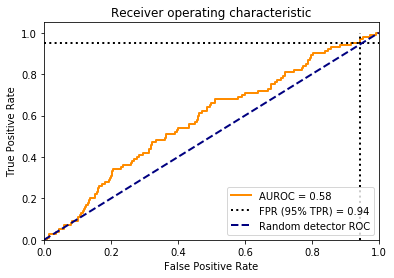

OOD Class 56
	Detection Err: 0.48895
	AUROC: 0.45637599999999995
	FPR@95%TPR: 0.9622


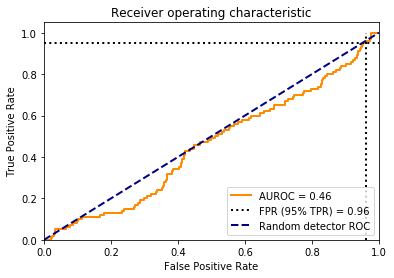

OOD Class 57
	Detection Err: 0.326
	AUROC: 0.7959630000000002
	FPR@95%TPR: 0.6912


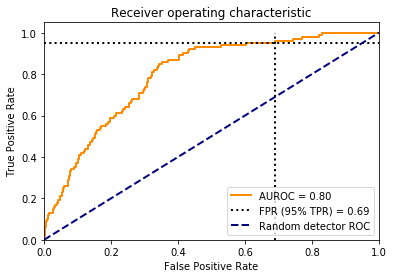

OOD Class 58
	Detection Err: 0.49895
	AUROC: 0.395769
	FPR@95%TPR: 0.9831


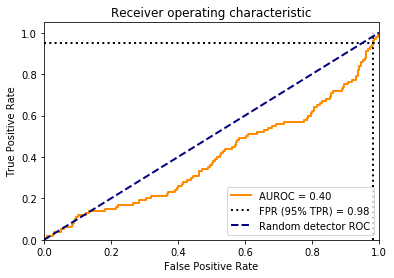

OOD Class 59
	Detection Err: 0.40365
	AUROC: 0.609021
	FPR@95%TPR: 0.7673


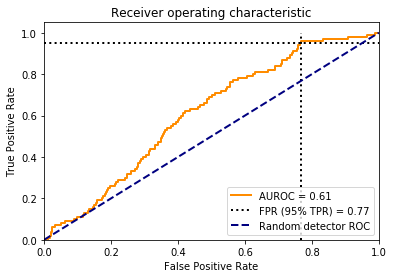

OOD Class 60
	Detection Err: 0.19985000000000003
	AUROC: 0.8907079999999999
	FPR@95%TPR: 0.3715


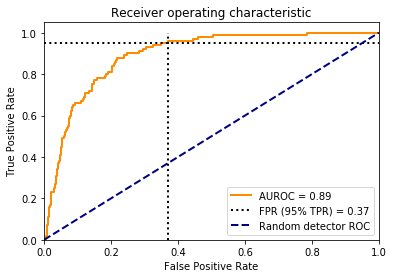

OOD Class 61
	Detection Err: 0.4572
	AUROC: 0.668042
	FPR@95%TPR: 0.8744


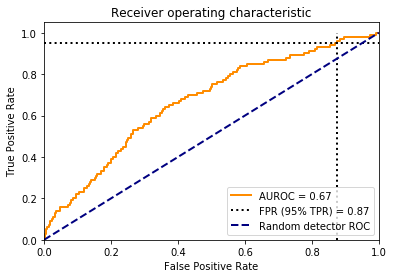

OOD Class 62
	Detection Err: 0.41685
	AUROC: 0.7786830000000001
	FPR@95%TPR: 0.8106


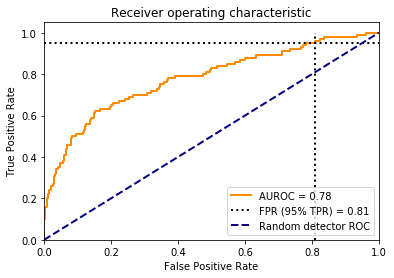

OOD Class 63
	Detection Err: 0.46915
	AUROC: 0.430807
	FPR@95%TPR: 0.903


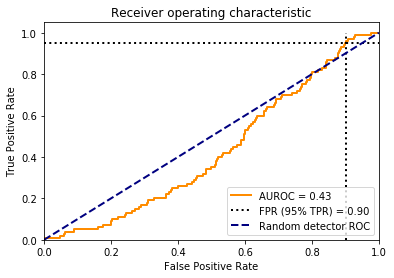

OOD Class 64
	Detection Err: 0.48200000000000004
	AUROC: 0.466985
	FPR@95%TPR: 0.931


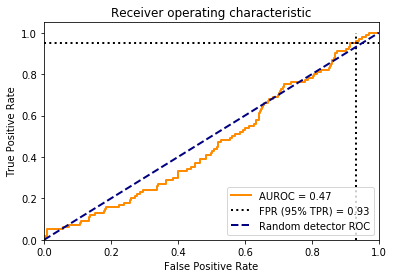

OOD Class 65
	Detection Err: 0.4966
	AUROC: 0.53384
	FPR@95%TPR: 0.9796


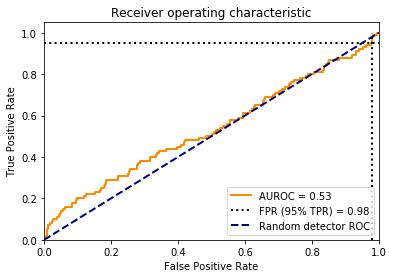

OOD Class 66
	Detection Err: 0.46725
	AUROC: 0.43932
	FPR@95%TPR: 0.8945


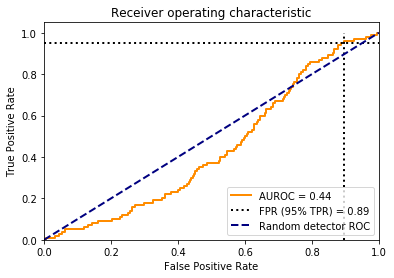

OOD Class 67
	Detection Err: 0.3678
	AUROC: 0.732395
	FPR@95%TPR: 0.7046


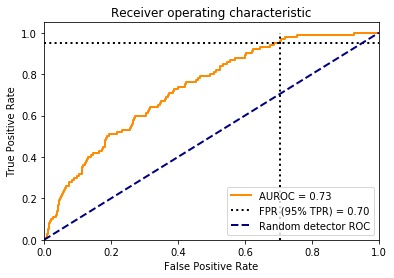

OOD Class 68
	Detection Err: 0.46240000000000003
	AUROC: 0.579647
	FPR@95%TPR: 0.8925


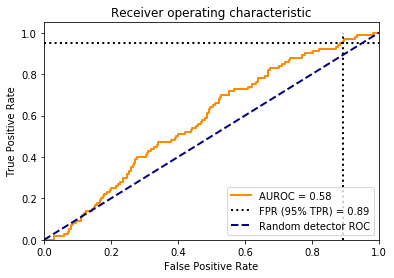

OOD Class 69
	Detection Err: 0.39365
	AUROC: 0.7275499999999999
	FPR@95%TPR: 0.7598


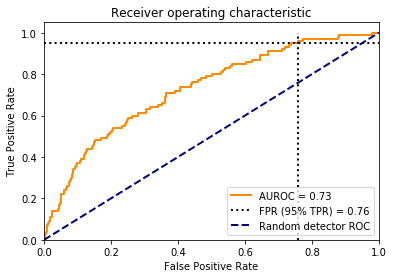

OOD Class 70
	Detection Err: 0.48255000000000003
	AUROC: 0.649759
	FPR@95%TPR: 0.9251


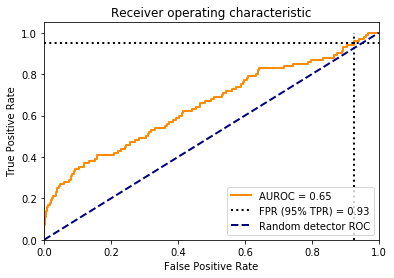

OOD Class 71
	Detection Err: 0.21240000000000003
	AUROC: 0.8841129999999999
	FPR@95%TPR: 0.4834


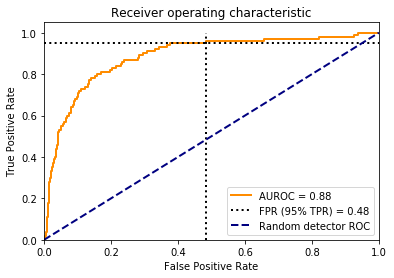

OOD Class 72
	Detection Err: 0.46585000000000004
	AUROC: 0.531998
	FPR@95%TPR: 0.8926


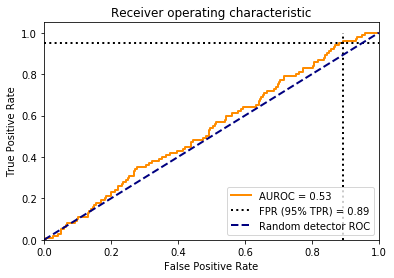

OOD Class 73
	Detection Err: 0.4268
	AUROC: 0.7232360000000001
	FPR@95%TPR: 0.8173


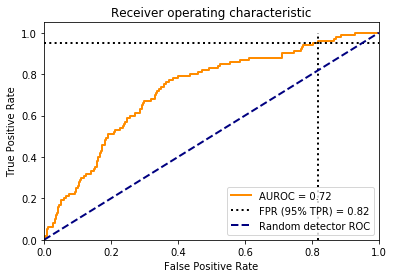

OOD Class 74
	Detection Err: 0.47955000000000003
	AUROC: 0.569741
	FPR@95%TPR: 0.9275


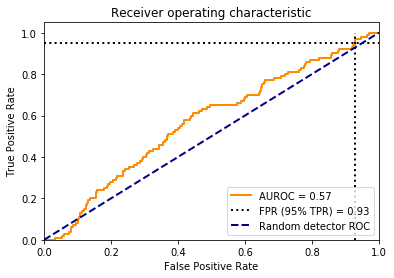

OOD Class 75
	Detection Err: 0.48495
	AUROC: 0.571883
	FPR@95%TPR: 0.9299


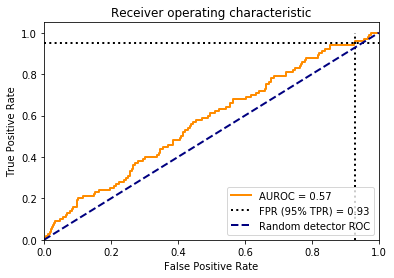

OOD Class 76
	Detection Err: 0.38915
	AUROC: 0.721585
	FPR@95%TPR: 0.7454


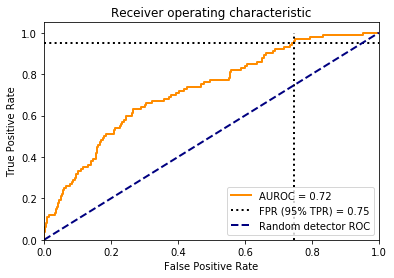

OOD Class 77
	Detection Err: 0.4799
	AUROC: 0.5729000000000001
	FPR@95%TPR: 0.9247


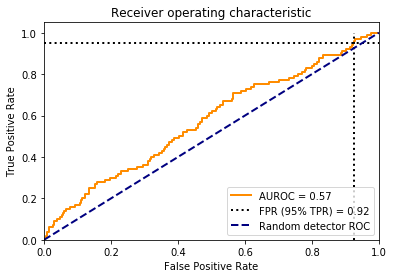

OOD Class 78
	Detection Err: 0.4207
	AUROC: 0.688213
	FPR@95%TPR: 0.8072


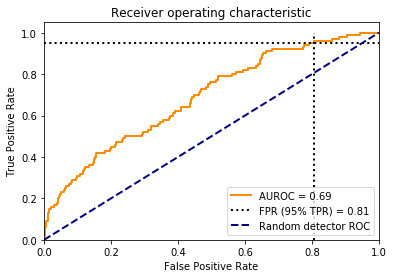

OOD Class 79
	Detection Err: 0.41035000000000005
	AUROC: 0.7279579999999999
	FPR@95%TPR: 0.789


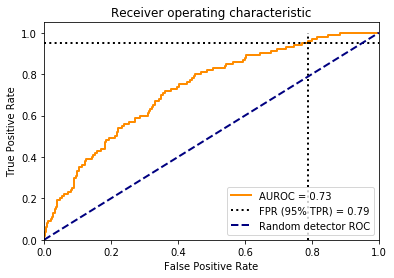

OOD Class 80
	Detection Err: 0.49265
	AUROC: 0.496606
	FPR@95%TPR: 0.9618


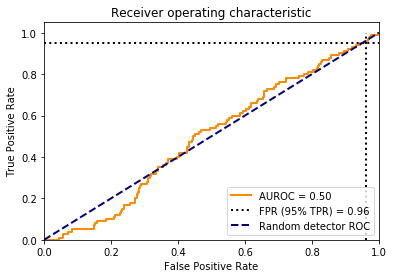

OOD Class 81
	Detection Err: 0.4999
	AUROC: 0.350932
	FPR@95%TPR: 0.9976


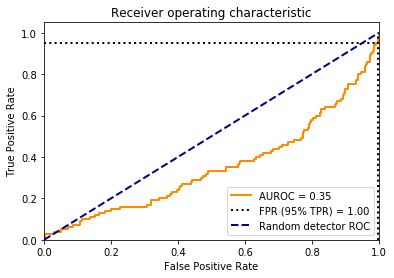

OOD Class 82
	Detection Err: 0.35685
	AUROC: 0.784398
	FPR@95%TPR: 0.6799


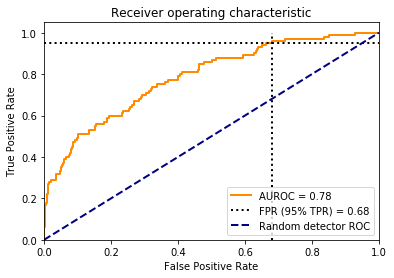

OOD Class 83
	Detection Err: 0.33180000000000004
	AUROC: 0.842182
	FPR@95%TPR: 0.6236


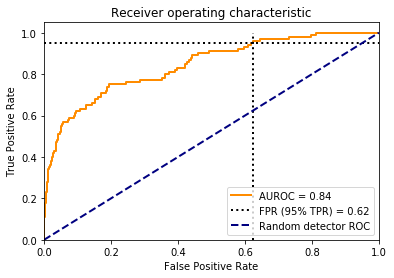

OOD Class 84
	Detection Err: 0.48425
	AUROC: 0.5687359999999999
	FPR@95%TPR: 0.9375


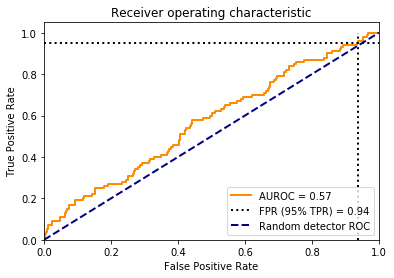

OOD Class 85
	Detection Err: 0.49460000000000004
	AUROC: 0.407065
	FPR@95%TPR: 0.9586


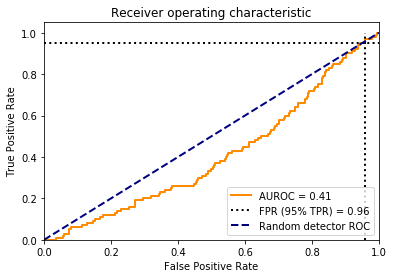

OOD Class 86
	Detection Err: 0.39975000000000005
	AUROC: 0.790591
	FPR@95%TPR: 0.76


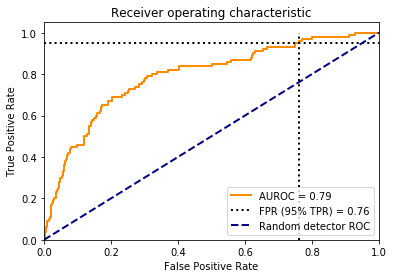

OOD Class 87
	Detection Err: 0.44470000000000004
	AUROC: 0.705899
	FPR@95%TPR: 0.8494


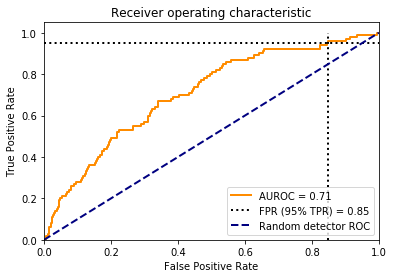

OOD Class 88
	Detection Err: 0.4884
	AUROC: 0.47659999999999997
	FPR@95%TPR: 0.9618


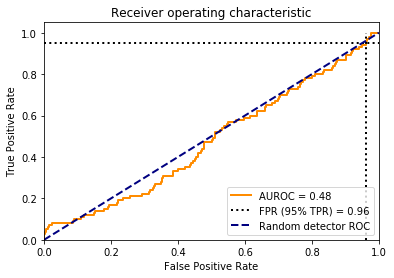

OOD Class 89
	Detection Err: 0.49975
	AUROC: 0.263324
	FPR@95%TPR: 0.9845


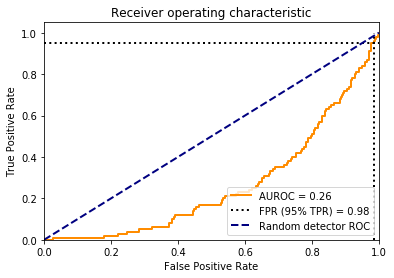

OOD Class 90
	Detection Err: 0.4991
	AUROC: 0.372112
	FPR@95%TPR: 0.9837


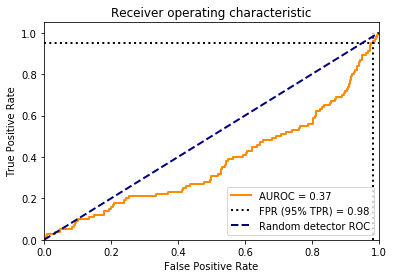

OOD Class 91
	Detection Err: 0.46950000000000003
	AUROC: 0.596819
	FPR@95%TPR: 0.9332


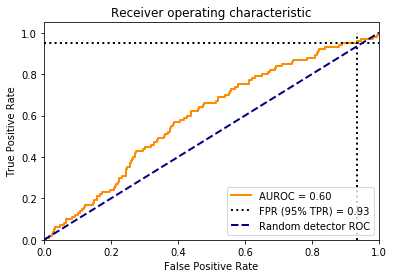

OOD Class 92
	Detection Err: 0.465
	AUROC: 0.747838
	FPR@95%TPR: 0.9388


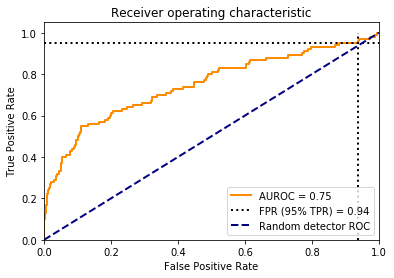

OOD Class 93
	Detection Err: 0.486
	AUROC: 0.523899
	FPR@95%TPR: 0.9456


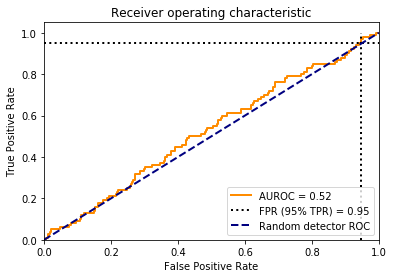

OOD Class 94
	Detection Err: 0.2524
	AUROC: 0.858815
	FPR@95%TPR: 0.4809


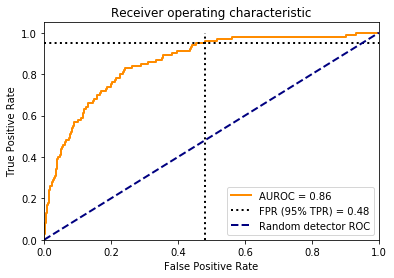

OOD Class 95
	Detection Err: 0.3437
	AUROC: 0.7219169999999999
	FPR@95%TPR: 0.6561


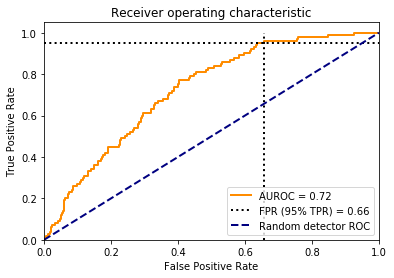

OOD Class 96
	Detection Err: 0.42095000000000005
	AUROC: 0.6891649999999999
	FPR@95%TPR: 0.8063


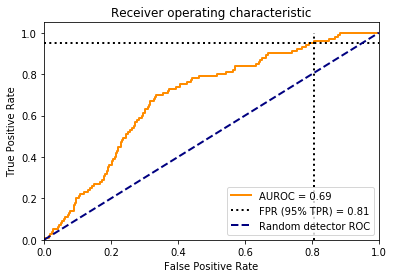

OOD Class 97
	Detection Err: 0.46575
	AUROC: 0.541533
	FPR@95%TPR: 0.9303


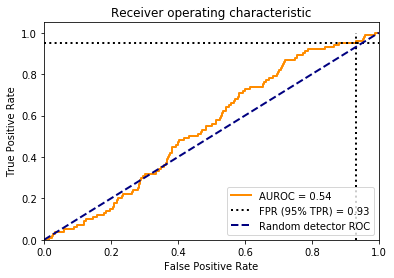

OOD Class 98
	Detection Err: 0.49625
	AUROC: 0.519046
	FPR@95%TPR: 0.9677


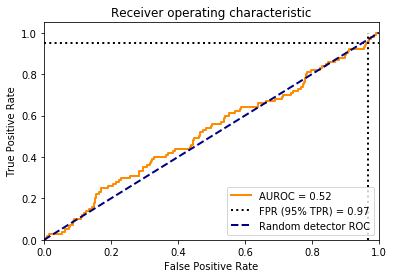

OOD Class 99
	Detection Err: 0.3042
	AUROC: 0.8614859999999999
	FPR@95%TPR: 0.5818


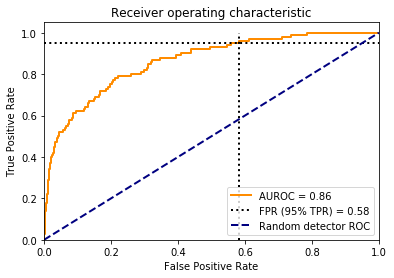

In [231]:
results = {}

data = load_ood_data('ood')

scores = -data['svm_scores']
labels = data['labels']

id_mask = labels < NUM_CLASSES

for ood_class in range(100):
    ood_mask = labels == ood_class + NUM_CLASSES  # OOD data labels are incremented by num inlier classes
    mask = ood_mask | id_mask
    
    masked_scores = scores[mask]

    masked_labels = labels[:]
    masked_labels[id_mask] = 0
    masked_labels[ood_mask] = 1
    masked_labels = labels[mask]
    
    results[ood_class] = calc_metrics(masked_scores, masked_labels)
    
    print(f"OOD Class {ood_class}")
    print(f"\tDetection Err: {results[ood_class]['detection_error']}")
    print(f"\tAUROC: {results[ood_class]['auroc']}")    
    print(f"\tFPR@95%TPR: {results[ood_class]['fpr_at_95_tpr']}")
    plot_roc(masked_scores, masked_labels)

In [232]:
CIFAR100_CLASSES = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


# Calc easiest to detect CIFAR100 classes

r = sorted(list(results.items()), key=lambda i: -i[1]['aupr_out'])

print("10 Easiest classes to detect:")
for i in range(10):
    print("\t",CIFAR100_CLASSES[r[i][0]])

print()
print("10 Hardest classes to detect:")
for i in range(10):
    print("\t",CIFAR100_CLASSES[r[-(i+1)][0]])
    
print()
print("CIFAR 10 ID classes:")
for i in range(10):
    print("\t",CIFAR10_CLASSES[i])

10 Easiest classes to detect:
	 keyboard
	 plain
	 cloud
	 sea
	 worm
	 wardrobe
	 orange
	 sweet_pepper
	 dolphin
	 pear

10 Hardest classes to detect:
	 tractor
	 streetcar
	 train
	 pickup_truck
	 house
	 bicycle
	 boy
	 girl
	 bus
	 cattle

CIFAR 10 ID classes:
	 airplane
	 automobile
	 bird
	 cat
	 deer
	 dog
	 frog
	 horse
	 ship
	 truck


# Try DBSCAN

In [253]:
data = load_ood_data('ood')

embedding = umap.UMAP().fit_transform(data['mahalanobis_features_train'])

In [257]:
colors = load_colors("tab20")

EPS: 0.05
Clusters: 1


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 50000

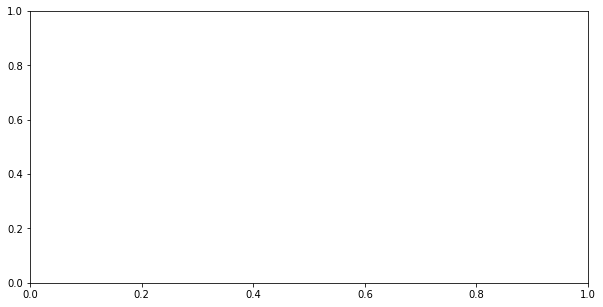

In [269]:
from sklearn.cluster import DBSCAN

for eps in np.arange(0.05, 0.5, 0.05):
    print("EPS:", eps)
    
    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    print("Clusters:", max(clustering.labels_))

    fig, ax = plt.subplots(figsize=(10, 5))

    for label in range(max(clustering.labels_) + 1):
        d = embedding[clustering.labels_ == label]

        x = d[:,0]
        y = d[:,1]
        ax.scatter(x, y, c=[colors[label % 20]], s=20, alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    # ax.legend()
    plt.show()

In [261]:
colors = load_colors("tab20")

EPS: 0.25
Clusters: 17


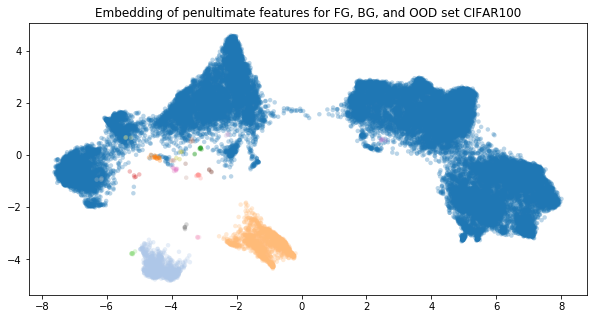

EPS: 0.3
Clusters: 12


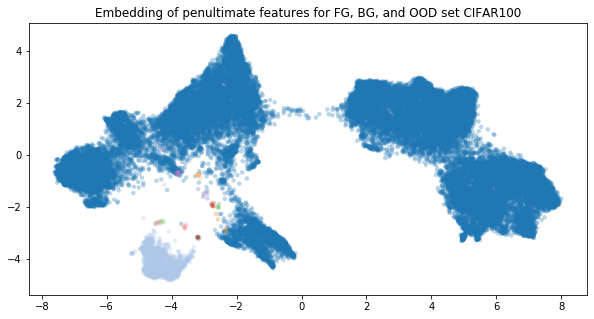

EPS: 0.35
Clusters: 10


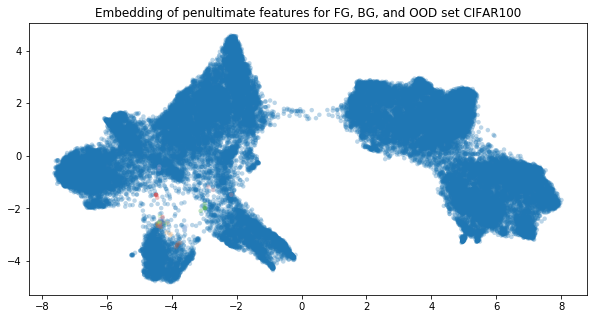

In [265]:
from sklearn.cluster import DBSCAN

for eps in [0.25, 0.3, 0.35]:
    print("EPS:", eps)

    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    print("Clusters:", max(clustering.labels_))

    fig, ax = plt.subplots(figsize=(10, 5))

    for label in range(max(clustering.labels_) + 1):
        d = embedding[clustering.labels_ == label]

        x = d[:,0]
        y = d[:,1]
        ax.scatter(x, y, c=[colors[label]], s=20, alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    # ax.legend()
    plt.show()

In [263]:
class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self

    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    print("Clusters:", max(clustering.labels_))

    fig, ax = plt.subplots(figsize=(10, 5))

    for label in range(max(clustering.labels_) + 1):
        d = embedding[clustering.labels_ == label]

        x = d[:,0]
        y = d[:,1]
        ax.scatter(x, y, c=[colors[label]], s=20, alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    # ax.legend()
    plt.show()

    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    print("Clusters:", max(clustering.labels_))

    fig, ax = plt.subplots(figsize=(10, 5))

    for label in range(max(clustering.labels_) + 1):
        d = embedding[clustering.labels_ == label]

        x = d[:,0]
        y = d[:,1]
        ax.scatter(x, y, c=[colors[label]], s=20, alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    # ax.legend()
    plt.show().fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels):
        """Fit parameters used for Mahalanobis distance."""
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        mahal_means = []
        print("Calculating mahal mean")
        for l in self.labels:
            mask = gt_labels == l
            mahal_means.append(gt_features[mask].mean(axis=0))#, dtype=np.float16))
            
        self.mahal_means = np.array(mahal_means)

        x = gt_features.copy()
        print("Calculating mahal cov")
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x[mask] -= self.mahal_means[i]

        self.mahal_cov = np.dot(x.T, x) / len(gt_features)
        print("Inverting")
        self.inv_mahal_cov = np.linalg.inv(self.mahal_cov + np.eye(len(self.mahal_cov)) * 1e-10)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        x =  -self.mahal_means + features
        m_x = np.diag(-np.dot(np.dot(x, self.inv_mahal_cov), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        max_i = np.argmax(m_x, axis=0)
        return np.array([self.labels[max_i], m_x[max_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmax(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.max(self(features), axis=0)
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.mahal_means)
            g.create_dataset("cov", data=self.mahal_cov)
            g.create_dataset("inv_cov", data=self.inv_mahal_cov)
            g.create_dataset("labels", data=self.inv_mahal_cov)
            
    @classmethod
    def load(cls, fname='mahal_distance.h5'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.labels = f['mahal_distance/labels'].value
            inst.mahal_means = f['mahal_distance/means'].value
            inst.mahal_cov = f['mahal_distance/cov'].value
            inst.inv_mahal_cov = f['mahal_distance/inv_cov'].value
        
        return inst

In [264]:
for eps in [0.35]:
    print("EPS:", eps)
    
    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    # Create a re-labled val set
    dset = data['mahalanobis_features_train'][clustering.labels_ >= 0]
    dlabels = clustering.labels_[clustering.labels_ >= 0]
    
    # Train a Mahal distance function
    md = Mahal_Dist(dset, dlabels)
    
    # Calculate the Performance of the Mahal distance function
    print("Calculating scores on validation set")
    scores = [md.dist(f) for f in data['mahalanobis_features']]
    labels = data['labels']
    


    clustering = DBSCAN(eps=eps, metric='cosine', n_jobs=-1).fit(data['mahalanobis_features_train'])

    print("Clusters:", max(clustering.labels_))

    fig, ax = plt.subplots(figsize=(10, 5))

    for label in range(max(clustering.labels_) + 1):
        d = embedding[clustering.labels_ == label]

        x = d[:,0]
        y = d[:,1]
        ax.scatter(x, y, c=[colors[label]], s=20, alpha=0.3, edgecolors='none')
        ax.set_title(f"Embedding of penultimate features for FG, BG, and OOD set {title}")

    # ax.legend()
    plt.show()    print(calc_metrics(scores, labels))

EPS: 0.35
Calculating mahal mean
Calculating mahal cov
Inverting
Calculating scores on validation set


ValueError: multiclass format is not supported

In [ ]:
scores = [md.dist(f) for f in data['mahalanobis_features']]
labels = data['labels']

In [ ]:
calc_metrics(scores, labels)